# 4.5 Detecting Human Body Keypoints

Module - Deep Vision

For book, references and training materials, please check this project website [http://activefitness.ai/ai-in-sports-with-python](http://activefitness.ai/ai-in-sports-with-python).

Reference: Chapter 6, [Applied Machine Learning for Health and Fitness](https://www.apress.com/us/book/9781484257715)

In [23]:
import torch
from torchvision import models

kprcnn = models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
kprcnn.eval()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
     

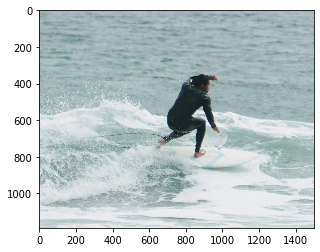

In [24]:
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

img = Image.open('./media/surfer.jpg')

plt.imshow(img)
plt.show()

In [25]:
import torchvision.transforms as T

def normalize(img):
    normalize_t = T.Compose([T.Resize(256),
                     T.CenterCrop(224),
                     T.ToTensor(), 
                     T.Normalize(mean = [0.485, 0.456, 0.406], 
                                 std = [0.229, 0.224, 0.225])])
    return normalize_t(img).unsqueeze(0)



img_tensor = normalize(img)
detection = kprcnn(img_tensor)[0]
detection

{'boxes': tensor([[ 93.7622,  59.6214, 165.8504, 146.9146],
         [ 88.3294,  36.8092, 177.4154, 202.8770]], grad_fn=<StackBackward>),
 'labels': tensor([1, 1]),
 'scores': tensor([0.9782, 0.2003], grad_fn=<IndexBackward>),
 'keypoints': tensor([[[148.9460,  73.7506,   1.0000],
          [148.1078,  73.4708,   1.0000],
          [146.7107,  73.4708,   1.0000],
          [118.4901, 113.4802,   1.0000],
          [140.8430,  71.5123,   1.0000],
          [145.5930,  89.4186,   1.0000],
          [123.5195,  79.9059,   1.0000],
          [143.9166, 118.2365,   1.0000],
          [151.7401, 109.2834,   1.0000],
          [136.3725, 146.7747,   1.0000],
          [104.5195, 134.1843,   1.0000],
          [124.6372, 110.6823,   1.0000],
          [110.3872, 109.0036,   1.0000],
          [144.1960, 115.4387,   1.0000],
          [145.3136, 115.9983,   1.0000],
          [136.0930, 146.7747,   1.0000],
          [106.7548, 133.0652,   1.0000]],
 
         [[149.0698,  77.4874,   1.0000],
 

In [26]:
def get_keypoint_detections(img, threshold=.7):
    with torch.no_grad():
        img_t = T.ToTensor()(img)
        img_t = img_t.unsqueeze(0)
        if next(kprcnn.parameters()).is_cuda:
            img_t = img_t.pin_memory().cuda(non_blocking=True)
        pred = kprcnn(img_t)[0]
    boxes = pred['boxes']
    kpts = pred['keypoints']
    box_scores = pred['scores']
    kpt_scores = pred['keypoints_scores']
    idxs = [i for (i,s) in enumerate(box_scores) if s > threshold]
    res = [(boxes[i].cpu().numpy(),kpts[i].cpu().numpy()) for i in idxs]
    return res

def to_json(preds):
    names = ["nose","left_eye","right_eye","left_ear","right_ear",
            "left_shoulder","right_shoulder","left_elbow","right_elbow",
            "left_wrist","right_wrist","left_hip","right_hip",
            "left_knee","right_knee","left_ankle","right_ankle"]
    detections = [k for (_,k) in preds]
    res = []
    for kpts in detections:
        d = {n:k.round().astype(int).tolist() for (n,k) in zip(names,kpts)}
        res.append(d)
    return json.dumps(res)


In [27]:
keypoint_detections = get_keypoint_detections(img)
json_keypoints = to_json(keypoint_detections)
json_keypoints

'[{"nose": [925, 418, 1], "left_eye": [924, 406, 1], "right_eye": [919, 408, 1], "left_ear": [887, 408, 1], "right_ear": [893, 409, 1], "left_shoulder": [801, 417, 1], "right_shoulder": [907, 476, 1], "left_elbow": [838, 375, 1], "right_elbow": [925, 566, 1], "left_wrist": [910, 366, 1], "right_wrist": [951, 632, 1], "left_hip": [713, 590, 1], "right_hip": [774, 626, 1], "left_knee": [774, 663, 1], "right_knee": [887, 614, 1], "left_ankle": [686, 709, 1], "right_ankle": [863, 766, 1]}]'

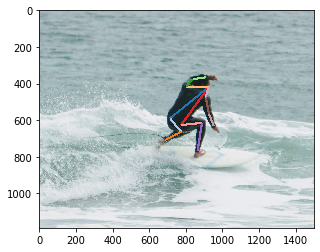

In [28]:
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

def drawline(draw, z, f, t, c):
    if f in z and t in z:
        draw.line((z[f][0], z[f][1], z[t][0], z[t][1]), fill=tuple(c), width=12)
        
def gen_colors():
    arr = plt.cm.tab20(np.linspace(0, 1, 20))
    arr=arr*255
    return arr.astype(int)
    
def draw_stickman(img, json_str):
    draw = ImageDraw.Draw(img)
    data = json.loads(json_str)
    z = data[0]
    colors = gen_colors()
    drawline(draw, z, 'left_hip', 'nose', colors[0])
    drawline(draw, z, 'left_hip', 'left_knee', colors[1])
    drawline(draw, z, 'left_knee', 'left_ankle', colors[2])
    drawline(draw, z, 'left_shoulder', 'nose', colors[3])
    drawline(draw, z, 'left_shoulder', 'left_elbow', colors[4])
    drawline(draw, z, 'left_elbow', 'left_wrist', colors[5])
    drawline(draw, z, 'right_hip', 'nose', colors[6])
    drawline(draw, z, 'right_hip', 'right_knee', colors[7])
    drawline(draw, z, 'right_knee', 'right_ankle', colors[8])
    drawline(draw, z, 'right_shoulder', 'nose', colors[9])
    drawline(draw, z, 'right_shoulder', 'right_elbow', colors[10])
    drawline(draw, z, 'right_elbow', 'right_wrist', colors[11])
    plt.imshow(img)
    plt.show()

draw_stickman(img, json_keypoints)